In [8]:
from collections import Counter
import numpy as np
import pysam
from scipy import stats
import click
import pyranges as pr
from concurrent.futures import ProcessPoolExecutor
from matplotlib import pyplot as plt
from collections import defaultdict

In [4]:
# 设置全局字体

import matplotlib.font_manager as font_manager
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12

# main

In [5]:
STRAND_TO_BOOL = {'-': True, '+': False}

In [6]:
# 1️⃣ 读取gene_bed信息

gene_model_bed = '/public/home/mowp/db/Arabidopsis_thaliana/isoform/araport11.gene.bed'
gene_model = pr.read_bed(gene_model_bed, as_df=True)
gene_model = gene_model.set_index(['Name'])
gene_model.head()

,Chromosome,Start,End,Score,Strand
Name,,,,,
AT1G01010,1,3629,5899,.,+
AT1G01020,1,6786,9130,.,-
AT1G03987,1,11099,11372,.,+
AT1G01030,1,11647,13714,.,-
AT1G01040,1,23119,31227,.,+


# result

In [11]:
from matplotlib import pyplot as plt

In [12]:
polya_cluster = '/public/home/mowp/data/total_RNA/nanopore_cdna/polya_sites/nanopore_cdna.polya_cluster.bed'
polya_cluster = pr.read_bed(polya_cluster, as_df=True)
polya_cluster['gene_id'] = polya_cluster.Name.map(lambda x: x.split('_')[0])

In [22]:
polya_cluster

,Chromosome,Start,End,Name,Score,Strand,ThickStart,gene_id
0,1,5820,5902,AT1G01010_1,16,+,3.453,AT1G01010
1,1,6762,6965,AT1G01020_1,113,-,5.099,AT1G01020
2,1,11601,11629,AT1G01030_1,22,-,3.516,AT1G01030
3,1,31142,31249,AT1G01040_1,103,+,4.441,AT1G01040
4,1,31114,31306,AT1G01050_1,596,-,5.071,AT1G01050
...,...,...,...,...,...,...,...,...
20704,5,26959508,26959682,AT5G67600_1,594,-,5.181,AT5G67600
20705,5,26960881,26961015,AT5G67610_1,89,-,4.774,AT5G67610
20706,5,26964767,26964775,AT5G67620_1,14,-,1.089,AT5G67620
20707,5,26967374,26967455,AT5G67630_1,122,-,3.846,AT5G67630


In [13]:
apa_num = polya_cluster.groupby(['gene_id']).apply(len)

In [14]:
np.histogram(apa_num, bins=np.arange(1, 10))

(array([15208,  2413,   206,    13,     1,     0,     0,     0]),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [15]:
x, y = [], []
for i in range(1, 3):
    x.append(i)
    y.append(len(apa_num[apa_num==i]))
x.append(3)
y.append(len(apa_num[apa_num>=3]))

In [16]:
x

[1, 2, 3]

In [17]:
y

[15208, 2413, 220]

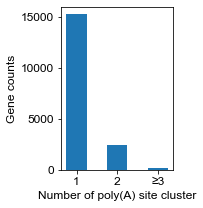

In [23]:
plt.figure(figsize=(2,3))
plt.bar(x=x, height=y, width=.5)
plt.ylabel('Gene counts')
plt.xlabel('Number of poly(A) site cluster')
plt.xticks([1,2,3], [1,2, '≥3'])
plt.show()

# overlap

In [24]:
import pybedtools

In [25]:
nanopore_cdna_bed = '/public/home/mowp/data/total_RNA/nanopore_cdna/polya_sites/nanopore_cdna.polya_cluster.bed'
nanopore_cdna_bed = pybedtools.example_bedtool(nanopore_cdna_bed)

In [27]:
drs_bed = '/public/home/mowp/data/total_RNA/notebook/plant_apa_db/AraDRS_WT_EXPR1.ERP001018.high_confidence.PAC.bed'
drs_bed = pybedtools.example_bedtool(drs_bed)

In [37]:
pas_bed = '/public/home/mowp/data/total_RNA/notebook/plant_apa_db/pas_seq.SRP013996_wildType.high_confidence.PAC.bed'
pas_bed = pybedtools.example_bedtool(pas_bed)

## nanopore vs drs

In [36]:
nano_and_drs = nanopore_cdna_bed.intersect(drs_bed, s=True)
len(nano_and_drs)

16250

## nanopore vs pas

In [38]:
nano_and_pas = nanopore_cdna_bed.intersect(pas_bed, s=True)
len(nano_and_pas)

15449

## DRS vs pas

In [41]:
drs_and_pas = drs_bed.intersect(pas_bed, s=True)
len(drs_and_pas)

15965

## nanopore vs drs vs pas

In [45]:
three_and = nano_and_drs.intersect(pas_bed, s=True)
len(three_and)

14976

In [46]:
pybedtools.contrib.venn_maker?

Type:        module
String form: <module 'pybedtools.contrib.venn_maker' from '/public/home/mowp/miniconda3/lib/python3.7/site-packages/pybedtools/contrib/venn_maker.py'>
File:        ~/miniconda3/lib/python3.7/site-packages/pybedtools/contrib/venn_maker.py
Docstring:  
Interface between pybedtools and the R package VennDiagram.

Rather than depend on the user to have rpy2 installed, this simply writes an
R script that can be edited and tweaked by the user before being run in R.


## venn plot

`venn_mpl.py 
  -a /public/home/mowp/data/total_RNA/nanopore_cdna/polya_sites/nanopore_cdna.polya_cluster.bed 
  -b /public/home/mowp/data/total_RNA/notebook/plant_apa_db/AraDRS_WT_EXPR1.ERP001018.high_confidence.PAC.bed 
  -c /public/home/mowp/data/total_RNA/notebook/plant_apa_db/pas_seq.SRP013996_wildType.high_confidence.PAC.bed 
  -o out.svg`

# nucleotide frequency

In [48]:
from Bio import SeqIO
infile = '/public/home/mowp/db/Arabidopsis_thaliana/dna/Arabidopsis_thaliana.TAIR10.dna.toplevel.fa'
genome = {}
for seq in SeqIO.parse(infile, 'fasta'):
    genome[seq.name] = seq.seq

In [83]:
def get_base_frequency(df, before=50, after=50):
    '''
    获取TTS上下游碱基频率分布
    '''
    STRAND_TO_BOOL = {'-': True, '+': False}
    length = before+after+1
    base_frequency = {'A':np.zeros(length), 'T':np.zeros(length), 'C':np.zeros(length), 'G':np.zeros(length),}
    for item in df.itertuples():
        gene_strand = STRAND_TO_BOOL[item.Strand]
        pas = item.End
        chrom = str(item.Chromosome)
        if gene_strand:
            seq = genome[chrom][pas-after-1: pas+before]
            seq = seq.reverse_complement()
        else:
            seq = genome[chrom][pas-before: pas+after+1]
            
        for n, base in enumerate(seq):
            if base in base_frequency:
                base_frequency[base][n] += 1
            else:
                logging.info(f'{base} base occured')
    return base_frequency


def plot_base_frequency(base_frequency, before=50, after=50):
    for n, base in enumerate(base_frequency):
        plt.plot(
            base_frequency[base]/(
                base_frequency['A'][n]
                + base_frequency['T'][n]
                + base_frequency['C'][n]
                + base_frequency['G'][n]), 
            label=base
        )

    plt.ylabel('Nucleotide frequency')
    plt.xlabel('Distance to PAS')
    plt.axvline(before, ls='--', color='#555555')
    ticks = np.linspace(0, before+after, 5, dtype='int')
    labels = np.linspace(-before, after, 5, dtype='int')
    plt.xticks(ticks, labels)
    plt.legend(frameon=False)

In [56]:
infile = '/public/home/mowp/data/total_RNA/nanopore_cdna/polya_sites/nanopore_cdna.polya_cluster.summit.bed'
polya_site = pr.read_bed(infile, as_df=True)

In [65]:
base_frequency = get_base_frequency(polya_site, before=100, after=100)

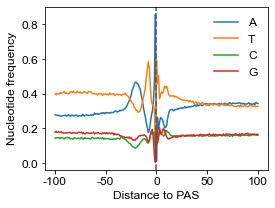

In [84]:
plt.figure(figsize=(4, 3))
plot_base_frequency(base_frequency, before=100, after=100)